###Commodity Channel Index 顺势指标

CCI 指标是根据统计学原理引进家个与固定期间的股价平均区间偏离程度的概念，强调股价平均绝对偏差在股市技术分析中的重要性。CCI专门测量股价是否已经超出常态分布范围。

过去N日CCI计算公式：CCI = (TP - MA) / MD / 0.015， 其中

TP = (最高价+最低价+收盘价）/3
MA = 最近N日收盘价的累计值和/N
MD = 最近N日（MA-收盘价）的累计值和/N
0.015为计算系数



## 策略核心思路：

对于基于经典技术指标CCI，按市场的通行标准， CCI在 (-100,100)之间股价处于窄幅震荡整理阶段， 投资者应以适当关注为主而：

当CCI<-100 时， 表明股价已经进入一个非常态区间，超卖区间， 因此
当CCI由小于-100变为大于-100时，开多仓； 
***
当CCI>100时， 表明股价已经进入另外一个非常态区间，超买区间， 因此
当CCI从大于100变为小于100时，开空仓；

Note：向量化前向填充思想实现策略 VS 循环法

简单的策略均可由向量填充法实现，但复杂的策略实现往往需要以循环法（将在布林带策略中使用）。

In [1]:
import numpy as np
import pandas as pd
import talib as ta
import tushare as ts

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# 确保可以显示‘-’号
mpl.rcParams['axes.unicode_minus']=False
# 确保中文显示正常
mpl.rcParams['font.sans-serif'] = ['SimHei']  

### 1. 数据获取和数据处理

In [5]:
# 获得历史数据并按时间升序排序
stock = ts.get_k_data('300059', '2018-08-17', '2020-08-17')

stock.head()

,date,open,close,high,low,volume,code
153,2018-08-17,12.72,12.39,12.77,12.36,753159.0,300059
154,2018-08-20,12.36,12.73,12.73,12.33,875812.0,300059
155,2018-08-21,12.65,12.77,12.96,12.62,924432.0,300059
156,2018-08-22,12.71,12.66,12.81,12.59,529813.0,300059
157,2018-08-23,12.70,12.95,13.03,12.68,1224311.0,300059


In [10]:
stock.set_index('date', inplace = True)

In [11]:
stock.tail()

,open,close,high,low,volume,code
date,,,,,,
2020-08-10,26.21,26.50,27.36,25.88,3703228.0,300059
2020-08-11,26.50,25.19,26.89,25.05,3888313.0,300059
2020-08-12,25.19,24.68,25.53,24.00,3922415.0,300059
2020-08-13,25.00,24.91,25.50,24.77,2690759.0,300059
2020-08-14,24.80,25.33,25.46,24.75,2130912.0,300059


In [15]:
# 计算CCI，取时间周期为20
stock['cci'] = ta.CCI(np.asarray(stock['high']), np.asarray(stock['low']), np.asarray(stock['close']), timeperiod=20)

In [16]:
stock.tail()

,open,close,high,low,volume,code,cci
date,,,,,,,
2020-08-10,26.21,26.50,27.36,25.88,3703228.0,300059,-2.781955
2020-08-11,26.50,25.19,26.89,25.05,3888313.0,300059,-61.456298
2020-08-12,25.19,24.68,25.53,24.00,3922415.0,300059,-125.421479
2020-08-13,25.00,24.91,25.50,24.77,2690759.0,300059,-88.680660
2020-08-14,24.80,25.33,25.46,24.75,2130912.0,300059,-82.908766


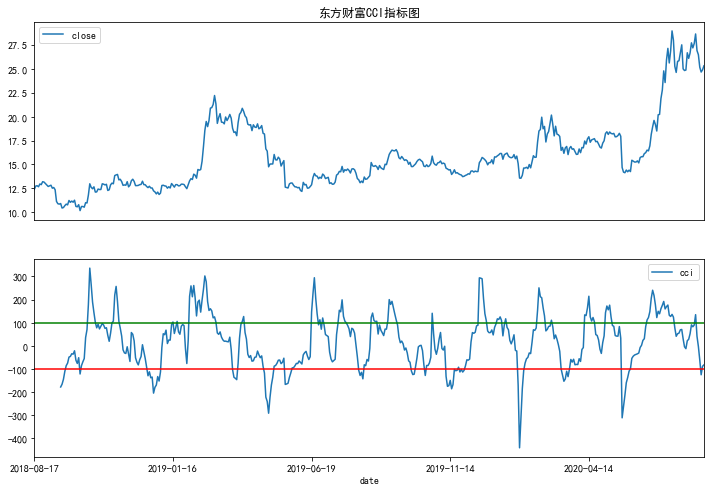

In [21]:
# 绘制cci指标图
plt.subplot(2, 1, 1)
plt.title('东方财富CCI指标图')
plt.gca().axes.get_xaxis().set_visible(False)
stock['close'].plot(figsize = (12,8))
plt.legend()
plt.subplot(2, 1, 2)
stock['cci'].plot(figsize = (12,8))
plt.axhline(100,color = 'g')
plt.axhline(-100, color = 'r')
plt.legend()
plt.show()

### 2.1 交易信号和策略逻辑

In [22]:
# 产生开仓信号时应使用昨日及前日cci，以避免未来数据
stock['yes_cci'] = stock['cci'].shift(1)
stock['daybeforeyes_cci'] = stock['cci'].shift(2)

In [23]:
#向量填充法-分开交易和持仓信号

# 产生开平仓交易信号
# 开多信号：当前二日cci小于-100，昨日cci大于-100则记为开多信号
stock['signal'] = np.where(np.logical_and(stock['daybeforeyes_cci']<-100, stock['yes_cci']>-100), 1, 0)

# 开空信号：当前二日cci大于100， 昨日cci小于100则记为开空信号
stock['signal'] = np.where((stock['daybeforeyes_cci']>100)& ( stock['yes_cci']<100),-1, stock['signal'])


In [24]:
stock.tail()

,open,close,high,low,volume,code,cci,yes_cci,daybeforeyes_cci,signal
date,,,,,,,,,,
2020-08-10,26.21,26.50,27.36,25.88,3703228.0,300059,-2.781955,41.204834,134.476759,-1
2020-08-11,26.50,25.19,26.89,25.05,3888313.0,300059,-61.456298,-2.781955,41.204834,0
2020-08-12,25.19,24.68,25.53,24.00,3922415.0,300059,-125.421479,-61.456298,-2.781955,0
2020-08-13,25.00,24.91,25.50,24.77,2690759.0,300059,-88.680660,-125.421479,-61.456298,0
2020-08-14,24.80,25.33,25.46,24.75,2130912.0,300059,-82.908766,-88.680660,-125.421479,1


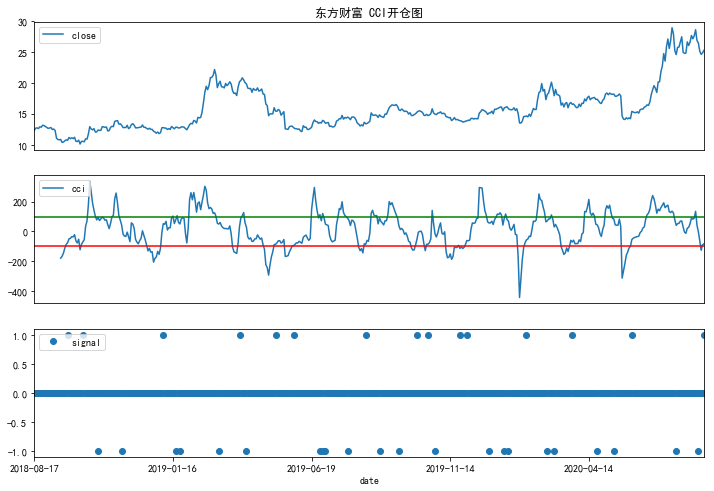

In [26]:
plt.subplot(3, 1, 1)
plt.title('东方财富 CCI开仓图')
plt.gca().axes.get_xaxis().set_visible(False)
stock['close'].plot(figsize = (12,8))
plt.legend(loc='upper left')

plt.subplot(3, 1, 2)
stock['cci'].plot(figsize = (12,8))
plt.axhline(100, color = 'g')
plt.axhline(-100, color = 'r')
plt.legend(loc='upper left')
plt.gca().axes.get_xaxis().set_visible(False)

plt.subplot(3, 1, 3)
stock['signal'].plot(figsize = (12,8),marker='o',linestyle='')
plt.legend(loc='upper left')
plt.show()

### 2.2 计算持仓

In [35]:
# 如果当天没有交易信号，设置为nan，如果有，取原来信号
stock['signal'] = np.where(stock['signal']==0, np.nan, stock['signal'])
# 通过前向填充生成持仓记录
stock['position'] = stock['signal'].fillna(method='ffill')
stock['signal'] = stock['signal'].fillna(0)

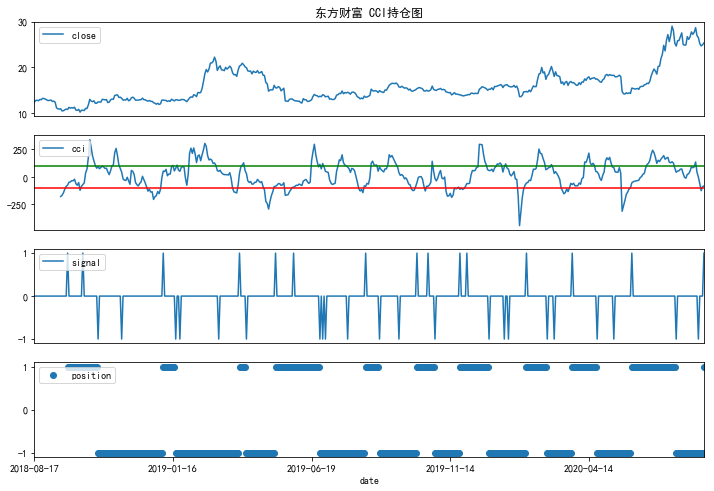

In [36]:
plt.subplot(4, 1, 1)
plt.title('东方财富 CCI持仓图')
plt.gca().axes.get_xaxis().set_visible(False)
stock['close'].plot(figsize = (12,8))
plt.legend(loc='upper left')

plt.subplot(4, 1, 2)
stock['cci'].plot(figsize = (12,8))
plt.axhline(100, color = 'g')
plt.axhline(-100, color = 'r')
plt.legend(loc='upper left')
plt.gca().axes.get_xaxis().set_visible(False)

plt.subplot(4, 1, 3)
stock['signal'].plot(figsize = (12,8))
plt.legend(loc='upper left')
plt.gca().axes.get_xaxis().set_visible(False)

plt.subplot(4, 1, 4)
stock['position'].plot(marker='o', figsize=(12,8),linestyle='')
plt.legend(loc='upper left')
plt.show()

In [37]:
stock.tail()

,open,close,high,low,volume,code,cci,yes_cci,daybeforeyes_cci,signal,position
date,,,,,,,,,,,
2020-08-10,26.21,26.50,27.36,25.88,3703228.0,300059,-2.781955,41.204834,134.476759,-1.0,-1.0
2020-08-11,26.50,25.19,26.89,25.05,3888313.0,300059,-61.456298,-2.781955,41.204834,0.0,-1.0
2020-08-12,25.19,24.68,25.53,24.00,3922415.0,300059,-125.421479,-61.456298,-2.781955,0.0,-1.0
2020-08-13,25.00,24.91,25.50,24.77,2690759.0,300059,-88.680660,-125.421479,-61.456298,0.0,-1.0
2020-08-14,24.80,25.33,25.46,24.75,2130912.0,300059,-82.908766,-88.680660,-125.421479,1.0,1.0


### 2.3 合并开仓平仓持仓信号

In [38]:
# 产生开平仓信号
# 开多信号：当前天cci小于-100，昨日cci大于-100则记为开多信号；
stock['signal'] = np.where(np.logical_and(stock['daybeforeyes_cci']<-100, stock['yes_cci']>-100), 1, np.nan)

# stock['signal'] = np.where((stock['daybeforeyes_cci']<-100) & (stock['yes_cci']>-100), 1, np.nan)

# 开空信号：当前天cci大于100， 昨日cci小于100则记为开空信号
stock['signal'] = np.where(np.logical_and(stock['daybeforeyes_cci']>100, stock['yes_cci']<100),-1, stock['signal'] )

stock['signal'] = stock['signal'].fillna(method='ffill')   #在下一个信号产生之前都是沿用上一个信号；

stock['signal'] = stock['signal'].fillna(0)

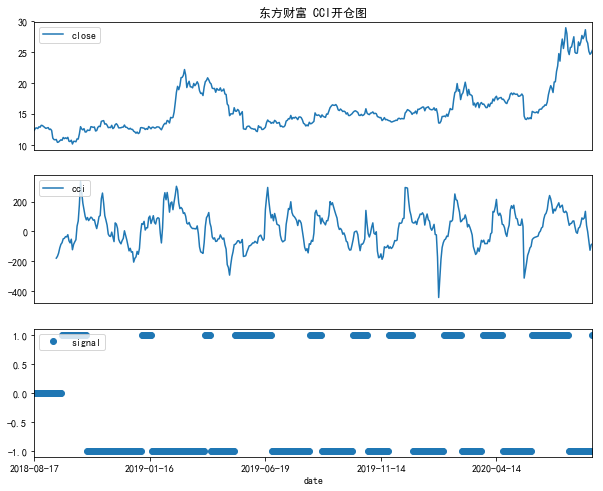

In [39]:
plt.subplot(3, 1, 1)
plt.title('东方财富 CCI开仓图')
plt.gca().axes.get_xaxis().set_visible(False)
stock['close'].plot(figsize = (10,8))
plt.legend(loc='upper left')
plt.subplot(3, 1, 2)
stock['cci'].plot(figsize = (10,8))
plt.legend(loc='upper left')
plt.gca().axes.get_xaxis().set_visible(False)
plt.subplot(3, 1, 3)
stock['signal'].plot(figsize = (10,8),marker='o',linestyle='')

plt.legend(loc='upper left')
plt.show()

### 3. 收益计算和净值绘制 (按照合并开仓持仓信号）

In [40]:
# 计算策略收益
# 计算股票每日收益率
stock['pct_change'] = stock['close'].pct_change()
# 计算策略每日收益率
stock['strategy_return'] = stock['pct_change'] * stock['signal']    #不用再加.shift(1);
# 计算股票累积收益率
stock['return'] = (stock['pct_change']+1).cumprod()
# 计算策略累积收益率
stock['strategy_cum_return'] = (1 + stock['strategy_return']).cumprod()

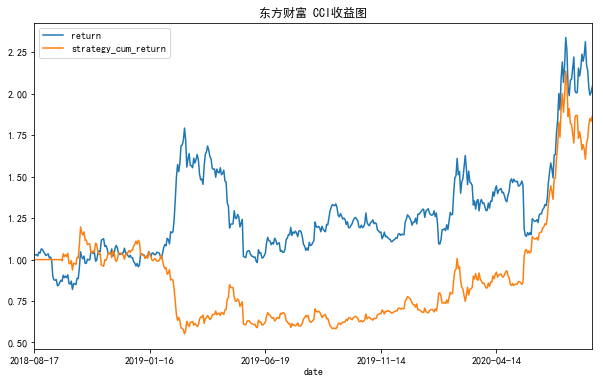

In [41]:
# 将股票累积收益率和策略累积收益率绘图
stock[['return', 'strategy_cum_return']].plot(figsize = (10,6))

plt.title('东方财富 CCI收益图')
plt.legend()